In [5]:
import json
import pandas as pd 
import re
import os

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from pprint import pprint

import pickle 
import pyLDAvis
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt
import numpy as np



# enregistrer le json dans le dossier de l'extension ?
#ajouter la channel
#application qui montre evolution débat ?

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mtlsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def load_data(name):
    # Opening JSON file
    f = open(name)
    data = json.load(f)
    df_data = pd.DataFrame(data).transpose()
    return df_data

In [10]:
def preprocess_data(df_data): 
    """_summary_

    Args:
        df_data : data is a Series of texte
    """
    # Remove punctuation
    df_data = df_data.map(lambda x: re.sub('[,\.!?/:;]', '', x))

    # Convert the titles to lowercase
    df_data= df_data.map(lambda x: x.lower())
    return df_data


<>:8: DeprecationWarning: invalid escape sequence '\.'
<>:8: DeprecationWarning: invalid escape sequence '\.'
C:\Users\mtlsa\AppData\Local\Temp\ipykernel_20232\4231314520.py:8: DeprecationWarning: invalid escape sequence '\.'
  df_data = df_data.map(lambda x: re.sub('[,\.!?/:;]', '', x))


In [17]:
def sentence2word(df_data):
    """_summary_

    Args:
        df_data (_type_): _description_

    Returns:
        list of list: list the words of each text
    """
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

    return [[word for word in simple_preprocess(str(doc)) 
        if word not in stop_words] for doc in df_data]

# simple_preprocess is a function of gensim.utils
# Convert a document into a list of tokens.

# This lowercases, tokenizes, de-accents (optional). 
# – the output are final tokens = unicode strings, that won’t be processed any further.

In [40]:
data = preprocess_data(load_data('navigation_data.txt')['video_description'])
data2word = sentence2word(data)


In [41]:
def create_cloud(df_data):
    # Join the different processed titles together.
    long_string = ','.join([ item for row in df_data for item in row])
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)

    return wordcloud

In [38]:
w = create_cloud(data2word)
w.to_image()

c:\Users\mtlsa\anaconda3\envs\IC05\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

## LSA Analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [42]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [43]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix


In [49]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix = prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = gensim.models.LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [50]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = gensim.models.LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [51]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    return x[np.argmax(coherence_values)],model_list[np.argmax(coherence_values)]



c:\Users\mtlsa\anaconda3\envs\IC05\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
c:\Users\mtlsa\anaconda3\envs\IC05\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\mtlsa\anaconda3\envs\IC05\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\mtlsa\anaconda3\envs\IC05\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprec

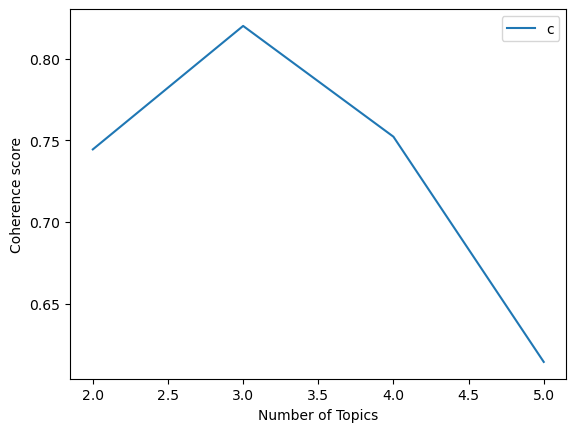

In [52]:
doc_clean = preprocess_data(load_data('navigation_data.txt')['video_description'].values)

start,stop,step=2,6,1
number_of_topics_opt,model_opt = plot_graph(doc_clean,start,stop,step)

In [53]:
# LSA Model
words=10
model_opt.print_topics(num_topics=number_of_topics_opt, num_words=words)
# clean_text=preprocess_data(df_data['video_description_processed'])
# model=create_gensim_lsa_model(clean_text,number_of_topics_opt,words)

[(0,
  '-0.654*"bilingu" + -0.378*"brain" + -0.206*"children" + -0.206*"benefit" + -0.172*"skill" + -0.172*"languag" + -0.155*"learn" + -0.120*"better" + -0.120*"social" + -0.103*"improv"'),
 (1,
  '-0.285*"product" + -0.285*"appétit" + -0.285*"bon" + -0.228*"produc" + -0.175*"http" + -0.171*"assist" + -0.171*"dessert" + -0.171*"director" + -0.171*"editor" + -0.171*"provid"'),
 (2,
  '0.268*"plu" + 0.268*"et" + 0.268*"de" + 0.179*"langu" + 0.179*"ted" + 0.179*"leçon" + 0.179*"une" + 0.179*"nacamulli" + 0.179*"il" + 0.179*"mia"')]

## LDA

In [55]:
preprocessed_data = preprocess_data(load_data('navigation_data.txt')['video_description'].values)
dictionary,doc_term_matrix = prepare_corpus(preprocessed_data)


In [57]:
# number of topics
num_topics = number_of_topics_opt
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                       id2word=dictionary,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]

[(0,
  '0.044*"bilingu" + 0.022*"brain" + 0.013*"benefit" + 0.012*"children" + '
  '0.011*"skill" + 0.011*"languag" + 0.009*"learn" + 0.008*"better" + '
  '0.008*"social" + 0.008*"recip"'),
 (1,
  '0.020*"bilingu" + 0.014*"brain" + 0.008*"children" + 0.007*"learn" + '
  '0.007*"languag" + 0.007*"benefit" + 0.006*"http" + 0.006*"skill" + '
  '0.006*"et" + 0.006*"de"'),
 (2,
  '0.033*"bilingu" + 0.020*"brain" + 0.012*"children" + 0.011*"benefit" + '
  '0.009*"learn" + 0.009*"skill" + 0.009*"languag" + 0.007*"improv" + '
  '0.006*"social" + 0.006*"better"')]


Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

Better understanding and interpreting individual topics, and
Better understanding the relationships between the topics.
For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [59]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.014384  0.000375       1        1  69.471562
2      0.002698 -0.001089       2        1  20.099066
1      0.011686  0.000713       3        1  10.429372, topic_info=         Term       Freq      Total Category  logprob  loglift
192   bilingu  29.000000  29.000000  Default  30.0000  30.0000
270     brain  16.000000  16.000000  Default  29.0000  29.0000
279  children   8.000000   8.000000  Default  28.0000  28.0000
342     learn   6.000000   6.000000  Default  27.0000  27.0000
206        et   1.000000   1.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
110    produc   0.342062   3.260986   Topic3  -5.4534   0.0058
43    develop   0.366586   4.902179   Topic3  -5.3842  -0.3327
111   product   0.348364   3.980545   Topic3  -5.4351  -0.1754
334    improv   0.349178   4.661822   Topic3  -5.4328  -0.3310
31        com   0.339805   3.512721   Topic3  -5.4600  -0.0752

[204 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
188       1  0.978672    animé
258       1  0.865946      app
258       2  0.288649      app
11        1  0.530327  appétit
11        2  0.265163  appétit
...     ...       ...      ...
162       1  0.814529      way
162       2  0.271510      way
164       1  0.866574   winter
240       1  0.970465        à
241       1  0.984555  évident

[155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])